In [65]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [66]:
data='https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

In [67]:
!wget $data

--2025-11-03 23:45:48--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.3’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.07s   

2025-11-03 23:45:49 (11.6 MB/s) - ‘car_fuel_efficiency.csv.3’ saved [874188/874188]



In [68]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [69]:
df.isna().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [70]:
df.head().T

,0,1,2,3,4
engine_displacement,170,130,170,220,210
num_cylinders,3.0,5.0,NaN,4.0,1.0
horsepower,159.0,97.0,78.0,NaN,140.0
vehicle_weight,3413.433759,3149.664934,3079.038997,2542.392402,3460.87099
acceleration,17.7,17.8,15.1,20.2,14.4
model_year,2003,2007,2018,2009,2009
origin,Europe,USA,Europe,USA,Europe
fuel_type,Gasoline,Gasoline,Gasoline,Diesel,Gasoline
drivetrain,All-wheel drive,Front-wheel drive,Front-wheel drive,All-wheel drive,All-wheel drive
num_doors,0.0,0.0,0.0,2.0,2.0


In [71]:
df = df.fillna(0)
df.isna().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [72]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [73]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [74]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [75]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [76]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

In [81]:
dr = DecisionTreeRegressor(max_depth=1)
dr.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [82]:
from sklearn.tree import export_text

print(export_text(dr, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



In [100]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [101]:
y_pred = dr.predict(X_val)
rmse(y_val, y_pred)

np.float64(1.6104639028827592)

In [102]:
# Q2 Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

rr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
rr.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [103]:
y_pred = rr.predict(X_val)
rmse(y_val, y_pred)

np.float64(0.4599777557336148)

In [107]:
# Q3 

rmses = []

for n in range(10,201,10):
    rr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=1)
    rr.fit(X_train, y_train)

    y_pred = rr.predict(X_val)
    score = rmse(y_val, y_pred)
    rmses.append((n, score))

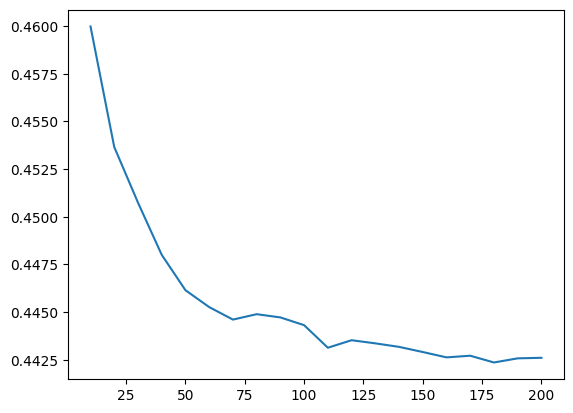

In [108]:
df_rmses = pd.DataFrame(rmses, columns=['n_estimators', 'rmse'])
plt.plot(df_rmses.n_estimators, df_rmses.rmse)

In [109]:
df_rmses

,n_estimators,rmse
0,10,0.459978
1,20,0.453659
2,30,0.450743
3,40,0.448007
4,50,0.446151
5,60,0.445266
6,70,0.444610
7,80,0.444893
8,90,0.444724
9,100,0.444318


In [110]:
# Q4

scores = []

for d in [10, 15, 20, 25]:
    for n in range(10,201,10):
        rr = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=1)
        rr.fit(X_train, y_train)
    
        y_pred = rr.predict(X_val)
        score = rmse(y_val, y_pred)
        scores.append((d, n, score))

In [117]:
df_scores = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'rmse'])
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.451895
1,10,20,0.448719
2,10,30,0.446225
3,10,40,0.443877
4,10,50,0.442682
...,...,...,...
75,25,160,0.442689
76,25,170,0.442767
77,25,180,0.442415
78,25,190,0.442618


In [121]:
df_scores.groupby('max_depth').mean()

,n_estimators,rmse
max_depth,,
10,105.0,0.442321
15,105.0,0.445060
20,105.0,0.445644
25,105.0,0.445661


In [122]:
# Q5

rr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=1)
rr.fit(X_train, y_train)

rr.feature_importances_

array([1.14707165e-02, 3.81809750e-04, 3.11842085e-04, 3.26932342e-03,
       3.43693411e-04, 3.36671988e-04, 1.60402148e-02, 3.18229841e-03,
       2.35867094e-03, 1.59113306e-03, 4.76103046e-04, 5.20358083e-04,
       5.55151959e-04, 9.59162013e-01])

In [123]:
features = list(dv.get_feature_names_out())
importances = rr.feature_importances_

In [124]:
for name, importance in zip(features, importances):
    print(f"{name}: {importance:.4f}")

acceleration: 0.0115
drivetrain=All-wheel drive: 0.0004
drivetrain=Front-wheel drive: 0.0003
engine_displacement: 0.0033
fuel_type=Diesel: 0.0003
fuel_type=Gasoline: 0.0003
horsepower: 0.0160
model_year: 0.0032
num_cylinders: 0.0024
num_doors: 0.0016
origin=Asia: 0.0005
origin=Europe: 0.0005
origin=USA: 0.0006
vehicle_weight: 0.9592


In [125]:
# Q6
import xgboost as xgb

In [126]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [127]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [128]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [129]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [130]:
y_pred = model.predict(dval)
rmse(y_val, y_pred)

np.float64(0.45017755678087246)

In [ ]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}